# IHC stained imaged data

This tutorial will guide you through the process of running SpaHDmap on IHC stained imaged ST data. Please see [HE-imaged ST](./HE-image.ipynb) for a more comprehensive introduction to SpaHDmap.

Our example data is a 10X Visium ST dataset MBC-01 sequenced from an adult mouse brain coronal section, comprising three immunohistochemistry (IHC) stained images (DAPI, Anti-GFAP, Anti-NeuN), we will take the IHC image and the spot expression data as input to run SpaHDmap. This data could be downloaded from [10X Genomics](https://www.10xgenomics.com/datasets/adult-mouse-brain-section-2-coronal-stains-dapi-anti-gfap-anti-neu-n-1-standard-1-1-0) or [Google Drive](https://drive.google.com/drive/folders/16L1nm3TzDDTFPVAaRXVKRp4LuCqvXbt2?usp=sharing).

## 1. Import necessary libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.chdir('docs/tutorials/')

In [2]:
import torch
import numpy as np
import scanpy as sc

import SpaHDmap as hdmap

/home/qk/anaconda3/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


## 2. Set the parameters and paths

In this section, we will set the parameters and paths for the SpaHDmap model, including:

**Parameters**:
- `rank`: the rank / number of components of the NMF model
- `seed`: the random seed
- `verbose`: whether to print the log information

**Paths**:
- `root_path`: the root path of the experiment
- `project`: the name of the project
- `results_path`: the path to save the results

### Parameters settings

By default, we set the `rank` to 20, the `seed` to 123, and the `verbose` to True. You can modify the parameters according to your data.

In [3]:
rank = 20
seed = 123
verbose = True

np.random.seed(seed)
torch.manual_seed(seed)

### Paths settings

These paths are set with respect to the current directory. You can modify the paths according to your data.

In [4]:
root_path = '../experiments/'
project = 'MBC01'

results_path = f'{root_path}/{project}/Results_Rank{rank}/'

## 3. Load the data and pre-process

The data used in this tutorial is a 10X Visium ST dataset MBC-01 sequenced from an adult mouse brain coronal section, could be downloaded from [10X Genomics](https://www.10xgenomics.com/datasets/adult-mouse-brain-section-2-coronal-stains-dapi-anti-gfap-anti-neu-n-1-standard-1-1-0) or [Google Drive](https://drive.google.com/drive/folders/16L1nm3TzDDTFPVAaRXVKRp4LuCqvXbt2?usp=sharing).

Next, we download the data from 10X Genomics using scanpy.

In [5]:
section_id = 'V1_Adult_Mouse_Brain_Coronal_Section_2'

# Download the data from the 10X website (set include_hires_tiff=True to download the hires image)
adata = sc.datasets.visium_sge(section_id, include_hires_tiff=True)
image_path = adata.uns["spatial"][section_id]["metadata"]["source_image_path"]

# or load the data from a local folder
# adata = sc.read_visium(f'data/{section_id}')
# image_path = f'data/{section_id}/image.tif'

/tmp/ipykernel_1235441/3088077163.py:4: FutureWarning: Use `squidpy.datasets.visium` instead.
  adata = sc.datasets.visium_sge(section_id, include_hires_tiff=True)


  0%|          | 0.00/5.88M [00:00<?, ?B/s]

  0%|          | 0.00/15.0M [00:00<?, ?B/s]

  0%|          | 0.00/3.28G [00:00<?, ?B/s]

/home/qk/anaconda3/lib/python3.11/site-packages/scanpy/datasets/_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qk/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Then we can load and preprocess the data.

In [6]:
# Load the data from an AnnData object
mouse_cortex = hdmap.prepare_stdata(adata=adata, section_name='mouse_cortex', image_path=image_path)

hdmap.select_svgs(mouse_cortex, n_top_genes=3000)

*** Reading and preparing AnnData for section mouse_cortex ***
Spot radius found in AnnData: 89
Pre-processing gene expression data for 2807 spots and 32285 genes.
Swapping x and y coordinates.
Processing image, seems to be Immunofluorescence image.
Selected 3000 SVGs using moran method.


In [7]:
mouse_cortex

STData object for section: mouse_cortex
Number of spots: 2807
Number of genes: 3000
Image shape: (3, 24240, 24240)
Scale rate: 1
Spot radius: 89
Image type: Immunofluorescence
Available scores: 

## 4. Run SpaHDmap

Same to case of analyzing HE-image 10X Visium ST data, we initialize the Mapper object and run SpaHDmap.

In [8]:
# Initialize the SpaHDmap runner
mapper = hdmap.Mapper(mouse_cortex, results_path=results_path, verbose=True)

# Run SpaHDmap in one function
mapper.run_SpaHDmap()

*** Preparing the tissue splits and creating pseudo spots... ***
*** Single section detected. Using its 3000 genes. ***
*** The split size is set to 256 pixels. ***
For section mouse_cortex, divide the tissue into 4495 sub-tissues, and create 15000 pseudo spots.
*** Using GPU ***
Step 1: Run NMF
*** Performing NMF... ***
*** Visualizing and saving the embeddings of NMF... ***
Step 2: Pre-train the SpaHDmap model
*** Pre-trained model found at ../experiments//MBC01/Results_Rank20//models//pretrained_model.pth, loading... ***
Step 3: Train the GCN model
*** Performing GCN... ***
*** Training GCN for mouse_cortex... ***
[Iter: 200 / 5000], Loss: 0.018455, Learning rate: 4.985215e-03
[Iter: 400 / 5000], Loss: 0.005902, Learning rate: 4.941093e-03
[Iter: 600 / 5000], Loss: 0.005357, Learning rate: 4.868331e-03
[Iter: 800 / 5000], Loss: 0.005235, Learning rate: 4.768075e-03
[Iter: 1000 / 5000], Loss: 0.005175, Learning rate: 4.641907e-03
[Iter: 1200 / 5000], Loss: 0.005133, Learning rate: 4.

After training, NMF, GCN and SpaHDmap scores are available now.

In [9]:
mouse_cortex

STData object for section: mouse_cortex
Number of spots: 2807
Number of genes: 3000
Image shape: (3, 24240, 24240)
Scale rate: 1
Spot radius: 89
Image type: Immunofluorescence
Available scores: NMF, GCN, VD, SpaHDmap, SpaHDmap_spot

*** Visualizing and saving the embeddings of NMF... ***


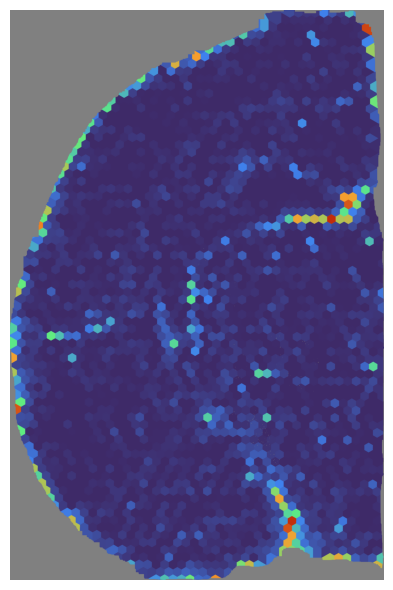

In [10]:
# Visualize the NMF score
mapper.visualize(mouse_cortex, use_score='NMF', index=18)

*** Visualizing and saving the embeddings of GCN... ***


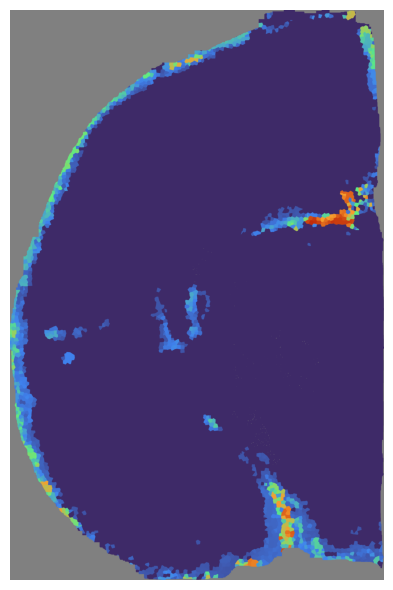

In [11]:
# Visualize the GCN score
mapper.visualize(mouse_cortex, use_score='GCN', index=18)

*** Visualizing and saving the embeddings of SpaHDmap... ***


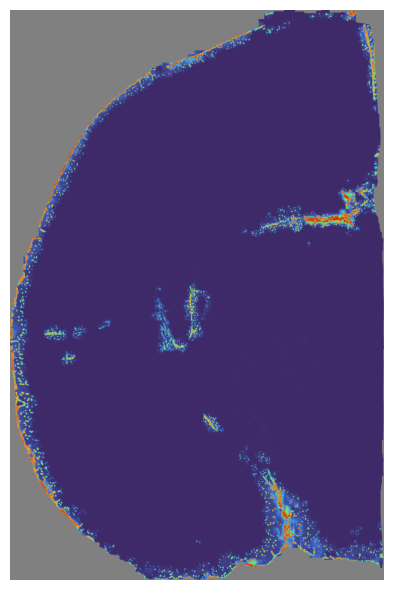

In [12]:
# Visualize the SpaHDmap score
mapper.visualize(mouse_cortex, use_score='SpaHDmap', index=18)

The final metagene matrix is stored in the `metagene` attribute of the Mapper object.

In [13]:
mapper.metagene.head()

Embedding_1  Embedding_2  Embedding_3  Embedding_4  Embedding_5  \
Ttr       0.653175     1.833360     1.759959     0.863542     0.635973   
Pmch      0.000000     0.134814     0.725159     4.474846     0.000000   
Nrgn      0.920033     1.430566     1.030315     1.025843     0.000000   
Mbp       0.261881     6.488406     3.927031     2.893169     0.787206   
Prkcd     0.089541     0.355763     3.671064     0.001683     0.100243   

       Embedding_6  Embedding_7  Embedding_8  Embedding_9  Embedding_10  \
Ttr       0.796727     1.724082    10.820923     0.743422      0.190398   
Pmch      0.284629     0.261490     0.288069     0.000000      0.120419   
Nrgn      2.993280     1.609028     0.361755     0.413251      3.758653   
Mbp       1.605631     2.251450     1.506694     0.748659      1.882908   
Prkcd     0.286054     0.074247     0.149027     0.076787      0.000000   

       Embedding_11  Embedding_12  Embedding_13  Embedding_14  Embedding_15  \
Ttr        4.749407      2.004940      2.177563      0.056810      1.462872   
Pmch       0.147249      0.000000      0.077970      0.000000      0.188201   
Nrgn       1.467950      0.440135      1.782942      1.484033      2.550623   
Mbp        2.831253      3.457766      1.625117      3.343159      2.528405   
Prkcd      0.084735      1.190819      0.000000      0.208558      0.000000   

       Embedding_16  Embedding_17  Embedding_18  Embedding_19  Embedding_20  
Ttr        0.241082      1.046943      0.373725      0.430738      0.987345  
Pmch       0.000000      0.181804      0.231371      0.141038      0.608212  
Nrgn       1.692670      3.061066      2.685826      1.156759      0.290362  
Mbp        2.594703      2.560298      1.524600      1.682140      3.647867  
Prkcd      0.322872      0.547407      0.000000      0.305845      0.579738

Finally, we can save the STData object:

In [14]:
mouse_cortex.save(results_path + 'mouse_cortex.st')